<a href="https://colab.research.google.com/github/CsanyiDavid/deepdream/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
print(tf.__version__)

2.15.0


Plan
* clip to valid range during optimization
* try inception model
* octave from tf tutorial

# First attempt



In [2]:
def image_properites(img, text=''):
    print(text, type(img), img.shape, img.dtype, np.min(img), np.max(img))

In [3]:
def inverse_preprocess_to_array(image):
    image = np.array(image)
    image[..., 0] += 103.939
    image[..., 1] += 116.779
    image[..., 2] += 123.68
    image = image[..., ::-1] #convert BGR to RGB
    return image

 <class 'numpy.ndarray'> (224, 224, 3) float32 0.0 255.0


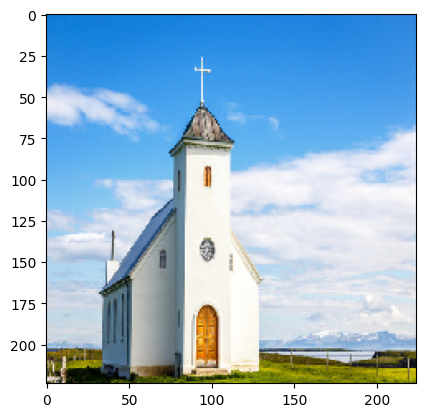

 <class 'numpy.ndarray'> (224, 224, 3) float32 0.0 255.0
 <class 'numpy.ndarray'> (1, 224, 224, 3) float32 -123.68 151.061


In [5]:
#Load and resize image
img_path = 'church.jpg'
img = keras.utils.load_img(img_path, target_size=(224, 224))
x = keras.utils.img_to_array(img)
image_properites(x)

plt.imshow(x/255.)
plt.show()

image_properites(x)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg19.preprocess_input(x)
image_properites(x)


In [6]:
vgg = keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

574710816/574710816 [==============================] - 4s 0us/step


In [7]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
output = vgg.predict(x)
print(np.max(output), np.argmax(output))
tf.keras.applications.vgg19.decode_predictions(
    output, top=1
)

1/1 [==============================] - 1s 960ms/step
0.94543165 497
35363/35363 [==============================] - 0s 0us/step


[[('n03028079', 'church', 0.94543165)]]

 <class 'numpy.ndarray'> (1, 224, 224, 3) int64 0 254


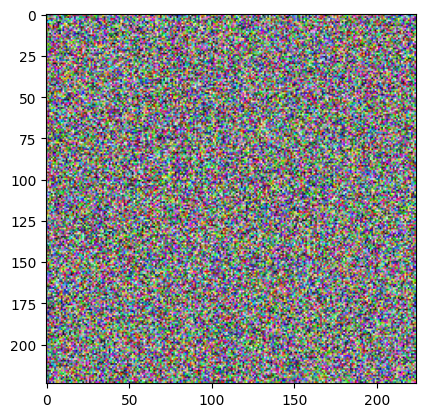

 <class 'numpy.ndarray'> (1, 224, 224, 3) float32 -123.68 150.061


In [9]:
noise = np.random.randint(0, 255, size=(1, 224, 224, 3))
image_properites(noise)
plt.imshow(noise[0])
plt.show()

noise = keras.applications.vgg19.preprocess_input(noise)
image_properites(noise)

In [10]:
output = vgg.predict(noise)
print(np.max(output), np.argmax(output))
tf.keras.applications.vgg19.decode_predictions(
    output, top=1
)

1/1 [==============================] - 1s 700ms/step
0.5325161 611


[[('n03598930', 'jigsaw_puzzle', 0.5325161)]]

In [12]:
deepdream_model = keras.models.Model(
    inputs = [vgg.input],
    outputs = [vgg.output[:, 152]] #Japanase spaniel
    #outputs = [vgg.output[:, 947]] #mushroom
    #outputs = [vgg.output[:, 947],
    #           vgg.output[:, 497],
    #           vgg.output[:, 937]]
    #outputs = [vgg.get_layer('flatten').output[0]]
    #outputs = [vgg.get_layer('block5_conv4').output[..., 0:10]]

)

In [13]:
def calculate_loss(image, model):
    output = model(image)
    if type(output) != list:
        output = [output]
    output = [tf.math.reduce_mean(i) for i in output]
    return -tf.reduce_mean(output)

In [14]:
print(calculate_loss(noise, deepdream_model))
print(calculate_loss(x, deepdream_model))

tf.Tensor(-3.3888168e-06, shape=(), dtype=float32)
tf.Tensor(-3.346103e-08, shape=(), dtype=float32)


In [15]:
input_image = tf.Variable(x)

In [17]:
def deepdream(image, model, steps=30, learning_rate=25):
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    dim_expanded = False
    if tf.rank(image) ==3:
        image = tf.expand_dims(image, axis=0)
        dim_expanded = True

    for step in range(steps):
        print('iteration ', step)
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = calculate_loss(image, model)
            grad = tape.gradient(loss, image)
            image_properites(grad, 'grad')
            grad /= tf.math.reduce_max(grad) + 1e-20
            image_properites(grad, 'scaled grad')
            optimizer.apply_gradients([(grad, image)])
            image_properites(image, 'input_image')

        print('\n')

    if dim_expanded:
        image = image[0]
    return image

In [18]:
result_image = deepdream(input_image, deepdream_model)

iteration  0
grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -5.338747e-11 3.8466057e-11
scaled grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -1.3879112 1.0
input_image <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (1, 224, 224, 3) <dtype: 'float32'> -148.67941 176.06062


iteration  1
grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -5.3480265e-09 4.3908615e-09
scaled grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -1.2179903 1.0
input_image <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (1, 224, 224, 3) <dtype: 'float32'> -173.7071 201.06714


iteration  2
grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -2.632164e-07 1.5367097e-07
scaled grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224,

 <class 'numpy.ndarray'> (1, 224, 224, 3) float32 -467.32428 710.0281


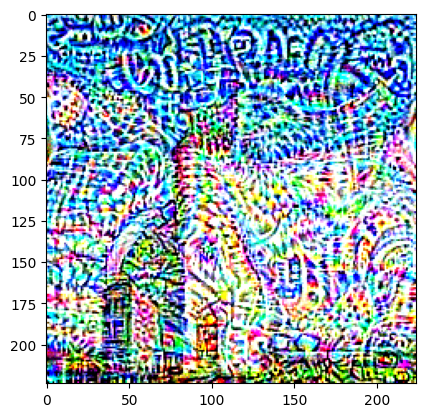

In [19]:
processed_image = inverse_preprocess_to_array(input_image)
image_properites(processed_image)
plt.imshow(processed_image[0]/255.)
plt.show()

In [20]:
output = vgg.predict(input_image)
print(np.max(output), np.argmax(output))
tf.keras.applications.vgg19.decode_predictions(
    output, top=1
)

1/1 [==============================] - 1s 687ms/step
0.9999994 152


[[('n02085782', 'Japanese_spaniel', 0.9999994)]]